In [1]:
# Don't forget to execute this cell
import bionetgen as pybng
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.optimize import minimize

# PyBioNetGen - a simple library for BioNetGen models

*PyBioNetGen* (PyBNG) is designed to be simple library to read and manipulate BNGL models that also serves as a convenient way to install bionetgen and quickly run models either from the command line or in python scripts. This library will also be the main platform for future development, we are working on improved model parsing and efficient simulators. 

This notebook is designed to showcase the basic features of the library side of PyBNG and simple things you can do directly from a python environment. See [here](https://pybionetgen.readthedocs.io/) for PyBNG documentation. 

We will cover some core use cases in this notebook

1. Running a model and plotting the results
2. Running a parameter scan
3. A linear sensitivity analysis
4. A simple parameter estimation (time permitting)

## (1) Running models and plotting results

PyBNG comes with a simple `run` command that simply executes the model you give it.

`run` command automatically reads all the output files and returns a results object. All output files are converted into `numpy record arrays`, see [here](https://numpy.org/doc/stable/reference/generated/numpy.recarray.html) for more information.

('time', 'S', 'I', 'R')


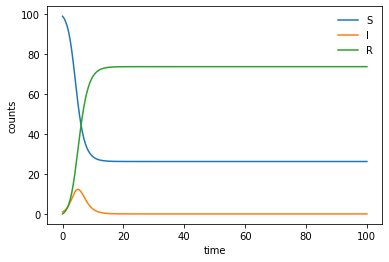

In [2]:
# change stuff here
file_to_run = "SIR.bngl"


# don't change anything after this

# this command runs the model in a temporary folder which is removed after execution is done
r = pybng.run(file_to_run, suppress=True)[0]

print(r.dtype.names) # this will print the names of the observables
# now we can loop over each observable name and plot them
for name in r.dtype.names:
    # we don't want to plot time
    if name != "time":
        # plot the observable values over time
        plt.plot(r['time'], r[name], label=name)
# label everything
plt.xlabel("time")
plt.ylabel("counts")
_ = plt.legend(frameon=False)

## (2) Running a parameter scan

A simple way to understand how a model behaves is to vary a parameter and see how observables change. There is a function in BNG that can do this but it's also very simple to do directly from Python using PyBNG.

BioNetGen version 2.8.3
Reading from file /tmp/tmp355sfz9v/SIR.bngl (level 0)
Read 4 parameters.
Read 3 species.
Read 3 observable(s).
Read 2 reaction rule(s).
Wrote model in xml format to ./SIR.xml.
Finished processing file /tmp/tmp355sfz9v/SIR.bngl.
CPU TIME: total 0.02 s.


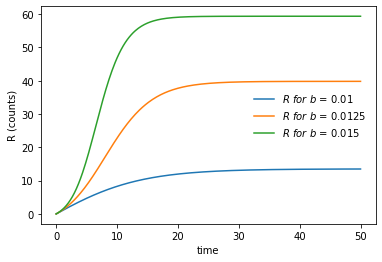

In [3]:
# change stuff here
file_to_run = "SIR.bngl"
parameter_to_scan = "b"
observables_to_plot = ["R"]
values_to_scan_over = [0.01,0.0125,0.015]
#values_to_scan_over = np.logspace(-2,-1,5)

# don't change anything after this
# load the model
model = pybng.bngmodel(file_to_run)
# clear all actions loaded from the BNGL
model.actions.clear_actions()
# add a simulate command 
model.add_action("simulate", action_args={"method":'"ode"',"t_end":50,"n_steps":300})
# loop over all parameter values
for i in values_to_scan_over:
    # change the parameter
    model.parameters[parameter_to_scan].expr = i
    # run can also take a model object as an argument
    # you can also suppress BNG output by using the keyword argument "suppress"
    result = pybng.run(model, suppress=True)[0]
    # plot the resutls
    for observable_to_plot in observables_to_plot:
        plt.plot(result['time'], result[observable_to_plot], 
            label=f"${observable_to_plot}\ for\ {parameter_to_scan}$ = "+f"{i}")
_ = plt.xlabel("time")
_ = plt.ylabel(f"{observable_to_plot} (counts)")
_ = plt.legend(frameon=False)

## Quick note on the libRoadrunner simulator

PyBNG allows easy generation of an SBML version of the BNGL file that can be used to generate a simulator that uses [libRoadrunner](https://www.libroadrunner.org/). This is an efficient simulator that runs in memory and avoids reading/writing files so it is more suitable for larger number of simulations for analyses like parameter sweeps, parameter estimations and sensitivity analyses. See the end of this notebook to learn how to use it, the rest of the analyses will be using this simulator. 

# (3) Sensitivity analysis

Sensitivity analysis is a method to determine how much parameters affect model behavior. This information can then be used guide other analyses, answer questions about a model or tune a particular observable to a specific value. e.g. We can disregard parameters that have very little effect on the model behavior and focus on changing parameters that have the most impact while trying to fit a model or we can tune the SIR model to have a specific number of dead cells by the end of the simulation. 

There are multiple methods to do global sensitivity analysis, we will use a linear regression global sensitivity analysis method. This analysis will involve three steps:

<ol type="a">
<li> Generate a set of parameter values over a broad range </li>
<li> Evaluate model observable for each parameter vector in the sample </li>
<li> Use multivariate linear regression to determine sensitivities of each parameter </li>
</ol>

### (3a) Generating a Parameter Sample

For the SIR model we will sample $\beta$ and $\gamma$ uniformly in $log$ space. It is a good idea to sample parameters like rate constants in log space rather than linear because they may vary by many orders of magnitude, and linear sampling will tend to wash out effects at smaller scales (low values). 

BioNetGen version 2.8.3
Reading from file /tmp/tmpek5klhul/SIR.bngl (level 0)
Read 4 parameters.
Read 3 species.
Read 3 observable(s).
Read 2 reaction rule(s).
Wrote model in xml format to ./SIR.xml.
Finished processing file /tmp/tmpek5klhul/SIR.bngl.
CPU TIME: total 0.03 s.
BioNetGen version 2.8.3
Reading from file temp.bngl (level 0)
Read 5 parameters.
Read 3 molecule types.
Read 3 species.
Read 3 observable(s).
Read 2 reaction rule(s).
ACTION: generate_network( temp )
Iteration   0:     3 species      0 rxns  0.00e+00 CPU s
Iteration   1:     3 species      2 rxns  0.00e+00 CPU s
Cumulative CPU time for each rule
Rule   1:     1 reactions 0.00e+00 CPU s 0.00e+00 CPU s/rxn
Rule   2:     1 reactions 0.00e+00 CPU s 0.00e+00 CPU s/rxn
Total   :     2 reactions 0.00e+00 CPU s 0.00e+00 CPU s/rxn
Wrote network in net format to ./temp.net.
CPU TIME: generate_network 0.01 s.
Wrote SBML to ./temp_sbml.xml.
CPU TIME: writeSBML 0.01 s.
Finished processing file temp.bngl.
CPU TIME: total 0.04 s.

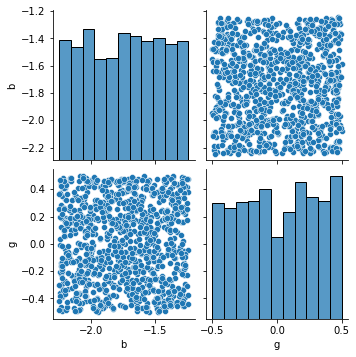

In [14]:
# change stuff here
file_to_run = "SIR.bngl"
order_of_magnitude = 1.0
params = ["b","g"] # sample over beta and gamma 
N = 1000 # number of samples

# don't change anything after this
model = pybng.bngmodel(file_to_run) # get a fresh version of the model 
sim = model.setup_simulator() # call setup_simulator, by default this will return a libRR simulator
# Define uniform sampling in log space of parameters beta and gamma
# make sure we are using original parameter values
sim.resetAll()
# One order of magnitude scan
logs = {}
for param in params:
    log_param = np.log10(getattr(sim, param))
    log_random = np.random.uniform(-0.5*order_of_magnitude,0.5*order_of_magnitude,N)
    logs[param] = log_param + log_random

# make pandas DataFrame for easier seaborn plotting
df = pd.DataFrame(logs)
# simple way to plot the parameter sample space
# diagonal plots are the 1D histograms of each log parameter
# off-diagonal plots are scatter plots of one parameter value vs the other
sns.pairplot(df)  
plt.show()

### (3b) Evaluate observables for each parameter sample

For this step, we need to run the model after setting each parameter according to the parameter sample vector. We then calculate an observable, in this case the observable will be the $\log_{10}$ of final number of dead cells (R). 

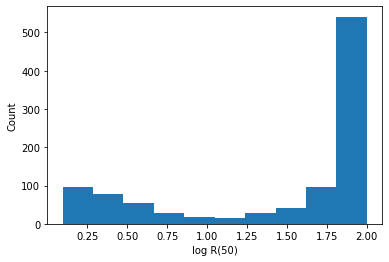

In [16]:
# this makes a new array where each row 
# is a parameter sample vector
X = np.stack(list(logs.values())).T
# initialize observable vector
O = np.zeros(N)
# loop over each parameter sample
for iparam, param_vec in enumerate(X):
    # reset concentrations
    sim.reset()
    # set beta/gamma values
    for ip,p in enumerate(params):
        setattr(sim, p, 10**param_vec[ip])
    # simulate with new parameters
    res=sim.simulate(0,50,200)
    # record observable
    O[iparam] = np.log10(res['R'][-1])
# plot the histogram of observables
plt.hist(O)
plt.xlabel(f'log R({50})')
_=plt.ylabel('Count')

### (3c) Evaluate observables for each parameter sample

For this step, we need to run the model after setting each parameter according to the parameter sample vector. We then calculate an observable, in this case the observable will be the $log_{10}$ of final number of dead cells (R). 

Correlation coefficients: [ 1.45679335 -1.43050379]
R2= 0.7630318460303773


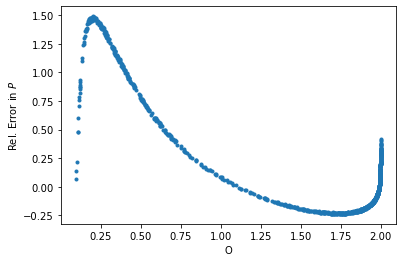

In [17]:
# import linear regression class
from sklearn.linear_model import LinearRegression
# instantiate the linear regression object
regmodel = LinearRegression(fit_intercept = True)
# use the parameter vector set and fit to the observable vector
fitted = regmodel.fit(X,O)
print("Correlation coefficients:",fitted.coef_)
print("R2=",fitted.score(X,O)) # R squared
# plot the relative error in our fit
plt.plot(O, (regmodel.predict(X) - O)/O,".")
plt.ylabel("Rel. Error in $P$")
_=plt.xlabel("Observable")

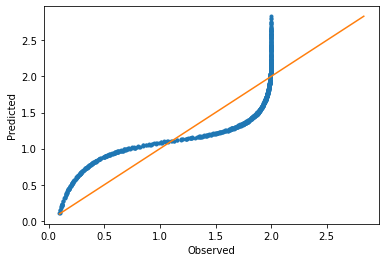

In [19]:
# let's see how well we did with our regression
# calculate predicted values from our fit
O_predict= regmodel.predict(X)
# plot observed values vs predicted values
plt.plot(O, O_predict,".")
# plot a x=y line to compare our predictions
lower= np.array([O_predict.min(),O.min()]).min()
upper= np.array([O_predict.max(),O.max()]).max()
orange= [lower,upper]
plt.plot(orange,orange)
plt.ylabel("Predicted")
_=plt.xlabel("Observed")

### Using sensitivity vector to tune observable values

A neat usage for the sensitivity vector is to use it to tune the observable in direction we want. E.g. the default version of our SIR model has ~70 dead cells by time 50. Say we want to have ~30 dead cells by that time instead.  

Dead cell count for base parameter values: 73.75233177607795
final dead cell count: 29.587285903750004, b: 0.01159010926630213, g: 1.0062942166792437


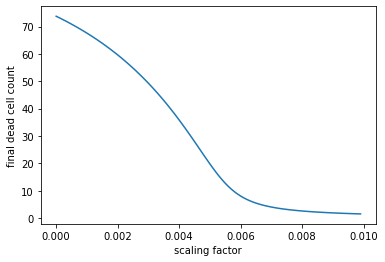

In [20]:
# go back to original values of the model
sim.resetAll()
# simulate and print the final dead cell count
r = sim.simulate(0,50,200)
print(f"Dead cell count for base parameter values: {r['R'][-1]}")

# original values
base_params = np.array([sim.b,sim.g])
coef = fitted.coef_
# scaling factors will need to be selected based on the model 
scaling_factors = np.arange(0,0.01,0.0001)
# initialized observable vector
obs = np.zeros(len(scaling_factors))
pars = np.zeros((len(scaling_factors),2))
found = False
# loop over our scaling factors
for iscale, scale in enumerate(scaling_factors):
    sim.reset()
    # we know our coefficients are for positive correlation 
    # so we subtract scaling factor * coefficient vector amount
    # from the original parameter set to decrease the final 
    # dead cell count 
    new_params = base_params - scale * coef
    # set parameters
    sim.b, sim.g = new_params[0], new_params[1]
    # simulate and save results
    r = sim.simulate(0,50,200)
    obs[iscale] = r['R'][-1]
    # simple way to print when we hit <30 final dead cell count
    if r['R'][-1] < 30 and not found:
        found = True
        print(f"final dead cell count: {r['R'][-1]}, b: {new_params[0]}, g: {new_params[1]}")
    pars[iscale] = new_params
# set labels
_ = plt.xlabel("scaling factor")
_ = plt.ylabel("final dead cell count")
_ = plt.plot(scaling_factors, obs)

# (4) Simple parameter estimation

A simple parameter estimation method can be done as follows 

1. Get experimental values that the model needs to fit to
2. Define a cost function that calculates the error between model results and experimental values
3. Use a minimization method to minimize the cost function

While there are many sophisticaed methods to do this process, we'll use the python library `scipy` and the `minimize` functionality it provides to do a simple parameter estimation. 

First, we will need to load our model and generate some fake "experimental" values by using parameter values that are unknown to the method we will be using and we will add noise to these values.

BioNetGen version 2.8.3
Reading from file /tmp/tmptg6sor3b/SIR.bngl (level 0)
Read 4 parameters.
Read 3 species.
Read 3 observable(s).
Read 2 reaction rule(s).
Wrote model in xml format to ./SIR.xml.
Finished processing file /tmp/tmptg6sor3b/SIR.bngl.
CPU TIME: total 0.03 s.
BioNetGen version 2.8.3
Reading from file temp.bngl (level 0)
Read 5 parameters.
Read 3 molecule types.
Read 3 species.
Read 3 observable(s).
Read 2 reaction rule(s).
ACTION: generate_network( temp )
Iteration   0:     3 species      0 rxns  0.00e+00 CPU s
Iteration   1:     3 species      2 rxns  0.00e+00 CPU s
Cumulative CPU time for each rule
Rule   1:     1 reactions 0.00e+00 CPU s 0.00e+00 CPU s/rxn
Rule   2:     1 reactions 0.00e+00 CPU s 0.00e+00 CPU s/rxn
Total   :     2 reactions 0.00e+00 CPU s 0.00e+00 CPU s/rxn
Wrote network in net format to ./temp.net.
CPU TIME: generate_network 0.01 s.
Wrote SBML to ./temp_sbml.xml.
CPU TIME: writeSBML 0.01 s.
Finished processing file temp.bngl.
CPU TIME: total 0.04 s.

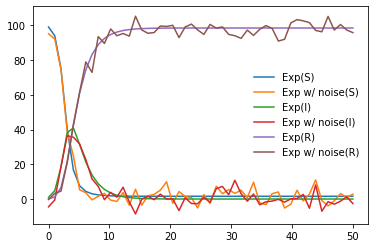

In [21]:
# change stuff here
file_to_run = "SIR.bngl"
params_to_estimate = ["b","g"] # sample over beta and gamma 
# these are the parameter values we will use to generate 
# the "experimental" values and will use our parameter 
# estimation to get these values back using that data
init_param_values = {"b": 0.021, "g": 0.5}  
observables_to_fit = ["S","I","R"]
t_start, t_end, n_steps = 0, 50, 50

# don't change anything after this
model = pybng.bngmodel(file_to_run) # get a fresh version of the model
sim = model.setup_simulator() # call setup_simulator, by default this will return a libRR simulator

# generate "experimental data" using the initial parameter values provided
for param_name in params_to_estimate:
    setattr(sim, param_name, init_param_values[param_name])
exp = sim.simulate(t_start, t_end, n_steps)

# add noise to the results
exp_with_noise = None
# comment after this if you don't want to add noise
exp_with_noise = np.array(np.zeros(exp.shape[0]), 
    dtype=np.dtype([(i,"f4") for i in exp.colnames])
)
exp_with_noise['time'] = exp["time"]
for obs_name in observables_to_fit:
    exp_with_noise[obs_name] = exp[obs_name] + np.random.normal(loc=0,scale=4,size=exp[obs_name].shape[0])

# plot the "experimental" results
for obs_name in observables_to_fit:
    plt.plot(exp["time"], exp[obs_name], label=f"Exp({obs_name})")
    if exp_with_noise is not None:
        plt.plot(exp_with_noise["time"], exp_with_noise[obs_name], label=f"Exp w/ noise({obs_name})")
_ = plt.legend(frameon=False)

if exp_with_noise is not None:
    exp = exp_with_noise

### Define cost function

We define a cost function that sets the parameters from a sample parameter vector, runs the simulation and calculates the average error between these results and the "experimental" results, returns the error to the `minimize` function. 

In [22]:
# define cost function
def cost(params):
    # reset the simulator state
    sim.reset()
    # set parameters
    sim.b = params[0]
    sim.g = params[1]
    # simulate
    res = sim.simulate(t_start, t_end, n_steps)
    # calculate total error
    tot_err = 0
    for obs_name in observables_to_fit:
        tot_err += np.sqrt(sum((exp[obs_name] - res[obs_name])**2))
    tot_err /= float(len(observables_to_fit))
    return tot_err

### Run minimization

Now that we have a cost function, we can use the `minimize` function to minimize the cost (error). See [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) for more information on how to use this function and learn more about the available minimization algorithms. 

In [23]:
minimized = minimize(cost, [0.0, 0.0], 
                        method='nelder-mead', tol=1e-6,
                        options={'maxiter': 1e3, 'disp': True})
print(f"Minimization finished")
print(minimized)
print("Final results")
print(f'initial b: {init_param_values["b"]}, estimated b: {minimized.x[0]}')
print(f'initial b: {init_param_values["g"]}, estimated b: {minimized.x[1]}')

Optimization terminated successfully.
         Current function value: 26.596875
         Iterations: 76
         Function evaluations: 144
Minimization finished
 final_simplex: (array([[0.02098657, 0.52479453],
       [0.02098658, 0.52479517],
       [0.02098659, 0.524795  ]]), array([26.59687477, 26.59687477, 26.59687477]))
           fun: 26.596874772827835
       message: 'Optimization terminated successfully.'
          nfev: 144
           nit: 76
        status: 0
       success: True
             x: array([0.02098657, 0.52479453])
Final results
initial b: 0.021, estimated b: 0.020986568011708836
initial b: 0.5, estimated b: 0.5247945321122016


If everything went well, the estimated values should be close to the initial values used to generate our fake experimental data. Let's compare them in a plot to see. 

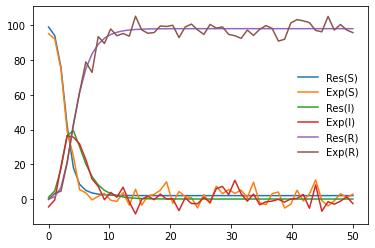

In [24]:
sim.resetAll()
for ip, param_name in enumerate(params_to_estimate):
    setattr(sim, param_name, minimized.x[ip])
res = sim.simulate(t_start,t_end,n_steps)
for obs_name in observables_to_fit:
    plt.plot(res["time"], res[obs_name], label=f"Res({obs_name})")
    plt.plot(exp["time"], exp[obs_name], label=f"Exp({obs_name})")
_ = plt.legend(frameon=False)

# Thank you for listening! 

# Everything that might be after this are extras.

### How to get a libRoadRunner simulator

To get a libRoadRunner simulator object, simply call the `setup_simulator` method of a model. If you have `libRoarRunner` library installed, you should get the simulator object. Note that Windows machines have occasional issues with this library. 

Let's tackle the same two tasks with this simulator before moving onto sensitivity analysis.

BioNetGen version 2.8.3
Reading from file /tmp/tmp6vdzxpz7/SIR.bngl (level 0)
Read 4 parameters.
Read 3 species.
Read 3 observable(s).
Read 2 reaction rule(s).
Wrote model in xml format to ./SIR.xml.
Finished processing file /tmp/tmp6vdzxpz7/SIR.bngl.
CPU TIME: total 0.01 s.
BioNetGen version 2.8.3
Reading from file temp.bngl (level 0)
Read 5 parameters.
Read 3 molecule types.
Read 3 species.
Read 3 observable(s).
Read 2 reaction rule(s).
ACTION: generate_network( temp )
Iteration   0:     3 species      0 rxns  0.00e+00 CPU s
Iteration   1:     3 species      2 rxns  0.00e+00 CPU s
Cumulative CPU time for each rule
Rule   1:     1 reactions 0.00e+00 CPU s 0.00e+00 CPU s/rxn
Rule   2:     1 reactions 0.00e+00 CPU s 0.00e+00 CPU s/rxn
Total   :     2 reactions 0.00e+00 CPU s 0.00e+00 CPU s/rxn
Wrote network in net format to ./temp.net.
CPU TIME: generate_network 0.01 s.
Wrote SBML to ./temp_sbml.xml.
CPU TIME: writeSBML 0.00 s.
Finished processing file temp.bngl.
CPU TIME: total 0.04 s.

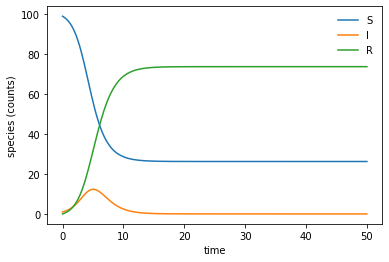

In [13]:
# change stuff here
file_to_run = "SIR.bngl"


# don't change anything after this
model = pybng.bngmodel(file_to_run) # get a fresh version of the model 
sim = model.setup_simulator() # call setup_simulator, by default this will return a libRR simulator
# This call will reset the simulator to its original state, this is there in case you 
# run this cell multiple times
sim.resetAll()
# simulate takes in 3 base arguments, (starting time, ending time, number of time points)
rr_result = sim.simulate(0,50,200)
# the result is a numpy array, we can loop over the names of each column
for name in rr_result.colnames:
    # we don't want to plot time
    if name != "time":
        # plot each time series over time
        plt.plot(rr_result['time'], rr_result[name], label=name)
# add labels and finish plotting
plt.xlabel("time")
plt.ylabel("species (counts)")
_ = plt.legend(frameon=False)